In the last notebook, we did initial exploration of how well a neural network could make predictions.  It seemed like it worked pretty well!  Now it's time to see if we can tune things a bit more.

As always, let's start with standard imports, then go on to loading data.

In [1]:
# Standard inputs
import pandas as pd
import numpy as np

# Make plots bigger
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
%matplotlib inline

import seaborn as sns
sns.set_palette('bright')

from src.data.load_dataset import load_and_count_by_band
from src.data.utils import plot_keras_history

hourly_20m = load_and_count_by_band(band='20m')
hourly_40m = load_and_count_by_band(band='40m')
hourly_80m = load_and_count_by_band(band='80m')

features_cnt = len(hourly_20m.columns) - 1

Next let's build up our model.  We'll use one that worked well in the last notebook: `tanh` for final activation, `SGD` for the optimizer, and `logcosh` for the loss function.

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


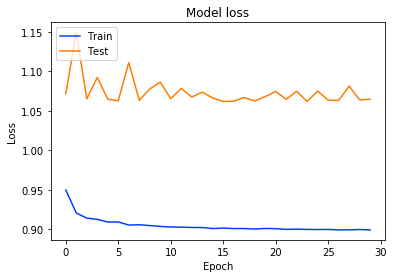

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras import optimizers, regularizers

model = Sequential([
    Dense(32, input_shape=(features_cnt,)),
    Activation('relu'),
    Dense(1),
    Activation('tanh')
])

# Use the logcosh regression
model.compile(optimizer=optimizers.SGD(lr=0.01),
                loss='logcosh')

# Set verbose to 0; we'll graph our progress instead.
history = model.fit(x=hourly_20m.drop('total', axis=1),
                    y=hourly_20m['total'],
                    validation_split=0.2,
                    shuffle=True,
                    epochs=30,
                    verbose=0)

plot_keras_history(history)

Cool: three cells, and we've got a trained model and a graph.  This is a lot more concise than last time. :-)

As for tuning...good question!  A quick search turns up the [Talos library](https://github.com/autonomio/talos) ([introductory article](https://towardsdatascience.com/hyperparameter-optimization-with-keras-b82e6364ca53)); let's give that a try.

In [3]:
from keras.activations import relu, elu, tanh

# Here we have a dictionary of items we want Talos to compare.
p = { 
    'first_neuron': [12, 24, 48],
    'activation': [relu, elu, tanh],
    'batch_size': [10, 20, 30],
}

# Here we make a function that Talos will use to create and evaluate our model
# See https://github.com/autonomio/talos/blob/master/examples/iris.py for an example.
def loostmap(x_train, y_train, x_val, y_val, params):
    model = Sequential()
    model.add(Dense(params['first_neuron'], input_shape=(features_cnt,)))
    model.add(Dense(1, activation='relu'))
    model.add(Dense(1, activation=params['activation']))
    model.compile(optimizer=optimizers.SGD(lr=0.01),
                  loss='logcosh')
    out = model.fit(x, y,
                    epochs=20,
                    batch_size=params['batch_size'],
                    validation_split=0.2,
                    shuffle=True,
                    verbose=0
    )
    
    return out, model

In [4]:
import talos as ta

def split_train_eval(df, ratio):
    rows = df.shape[0]
    rows = int(rows * ratio)
    train_data, eval_data = np.split(df, [rows,], axis=0)
    return train_data, eval_data

train_data, eval_data = split_train_eval(hourly_20m, 0.9)
#t = ta.Scan(x, y, p, loostmap)
x = hourly_20m.drop('total', axis=1)
y = hourly_20m['total']

out, model = loostmap(train_data.drop('total', axis=1), 
                      train_data['total'],
                      eval_data.drop('total', axis=1),
                      eval_data['total'],
                      {'first_neuron': 12,
                       'activation': relu,
                       'batch_size':10})

print(out)

In [5]:
# The suggestion to use `.values` came from https://github.com/autonomio/talos/issues/130#issuecomment-470038009
t = ta.Scan(x=train_data.drop('total', axis=1).values,
            y=train_data['total'].values,
            model=loostmap,
            params=p,
            val_split=0.2)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 27/27 [06:06<00:00, 15.81s/it]


In [6]:
t.details

random_method          uniform_mersenne
reduction_method                   None
reduction_interval                   50
reduction_window                     20
grid_downsample                       1
reduction_threshold                 0.2
reduction_metric                val_acc
reduce_loss                       False
experiment_name           100619153713_
complete_time            10/06/19/15:43
x_shape                      (11962, 6)
y_shape                        (11962,)
dtype: object

In [7]:
len(t.saved_models)

27

In [8]:
r = ta.Reporting(t)
r.data.head(-3)

round_epochs  val_loss      loss  first_neuron  \
0             20  1.089048  0.922648            24   
1             20  1.071744  0.909761            24   
2             20  1.071697  0.909744            48   
3             20  1.071490  0.909740            12   
4             20  1.071677  0.909775            48   
5             20  1.071802  0.909750            12   
6             20  1.071605  0.909774            12   
7             20  1.089048  0.922648            48   
8             20  1.089048  0.922638            24   
9             20  1.089048  0.922648            12   
10            20  1.071783  0.909765            48   
11            20  1.069732  0.903705            48   
12            20  1.065826  0.902308            48   
13            20  1.071751  0.909736            12   
14            20  1.068904  0.904044            48   
15            20  1.071649  0.909673            12   
16            20  1.065398  0.901302            24   
17            20  1.071662  0.909772            24   
18            20  1.071774  0.909746            24   
19            20  1.089048  0.922648            12   
20            20  1.089048  0.922648            48   
21            20  1.071755  0.909756            24   
22            20  1.071762  0.909757            12   
23            20  1.088456  0.922361            12   

                           activation  batch_size  
0   <function relu at 0x7f4b5a7738c0>          10  
1    <function elu at 0x7f4b5a773680>          10  
2    <function elu at 0x7f4b5a773680>          20  
3   <function tanh at 0x7f4b5a773950>          10  
4    <function elu at 0x7f4b5a773680>          10  
5    <function elu at 0x7f4b5a773680>          30  
6    <function elu at 0x7f4b5a773680>          10  
7   <function relu at 0x7f4b5a7738c0>          20  
8   <function relu at 0x7f4b5a7738c0>          30  
9   <function relu at 0x7f4b5a7738c0>          20  
10  <function tanh at 0x7f4b5a773950>          30  
11  <function tanh at 0x7f4b5a773950>          20  
12  <function tanh at 0x7f4b5a773950>          10  
13  <function tanh at 0x7f4b5a773950>          30  
14   <function elu at 0x7f4b5a773680>          30  
15  <function tanh at 0x7f4b5a773950>          20  
16   <function elu at 0x7f4b5a773680>          20  
17  <function tanh at 0x7f4b5a773950>          10  
18   <function elu at 0x7f4b5a773680>          30  
19  <function relu at 0x7f4b5a7738c0>          30  
20  <function relu at 0x7f4b5a7738c0>          10  
21  <function tanh at 0x7f4b5a773950>          20  
22   <function elu at 0x7f4b5a773680>          20  
23  <function relu at 0x7f4b5a7738c0>          10

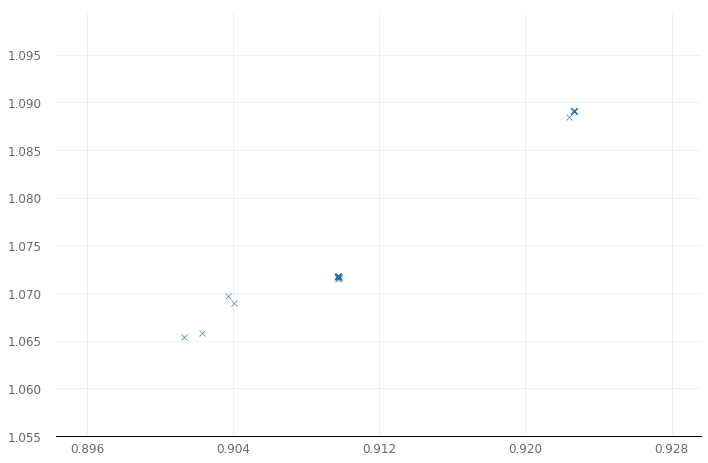

In [9]:
r.plot_regs(x='loss')

In [10]:
t_best=t.best_model(metric='val_loss')
print(t_best.to_json(indent=2))

{
  "class_name": "Sequential",
  "config": {
    "name": "sequential_3",
    "layers": [
      {
        "class_name": "Dense",
        "config": {
          "name": "dense_6",
          "trainable": true,
          "batch_input_shape": [
            null,
            6
          ],
          "dtype": "float32",
          "units": 24,
          "activation": "linear",
          "use_bias": true,
          "kernel_initializer": {
            "class_name": "VarianceScaling",
            "config": {
              "scale": 1.0,
              "mode": "fan_avg",
              "distribution": "uniform",
              "seed": null
            }
          },
          "bias_initializer": {
            "class_name": "Zeros",
            "config": {}
          },
          "kernel_regularizer": null,
          "bias_regularizer": null,
          "activity_regularizer": null,
          "kernel_constraint": null,
          "bias_constraint": null
        }
      },
      {
        "class_name": "D

Not bad -- we have a model, it seems to make predictions, and the loss is not too bad.  From here, we can go in a few different directions:

- We can save the model and use it to make predictions against other ranges (Q2 2019, for example)
- We could try to deploy this in a web framework like Flask

I'm going to start with the first item in the list:  save the model, and use it to make predictions.

In [11]:
t_best.save('../models/notebook_07-hpb-ve7cc-2019q1-neural-network-tuning.h5')

On to the next notebook!